In [116]:
import numpy as np
import random
import os
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse
from tqdm import tqdm

from setup_networks import network_from_txt, network_indices, Network, network_from_edges_and_nodes
from currents import * 
from adaptation import adaptation_ode, ss_solve
from measures import steady_state_dissipation


In [117]:
def get_path_lengths(netw, source, sinks, K):
    G = nx.Graph()
    node_pos = netw.pos
    nodes = np.arange(len(node_pos))
    weighted_edges = np.append(edges, 1/K[:, np.newaxis], 1)
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges, weight='K')
    
    path_length = 0
    path_weight = 0
    for s in sinks:
        path = nx.dijkstra_path(G, inds['left'], s, weight='K')
        pathweight = nx.path_weight(G, path, weight='K')
        
        path_length += len(path)
        path_weight += pathweight
        
    N_sinks = len(sinks)
    return path_length/N_sinks, path_weight/N_sinks

In [118]:
N_kappas = 5
N_rhos = 5
N_sinks = 50
N_replicates=10

kappas = np.logspace(-3, 0, N_kappas)
rhos = np.logspace(0, 2, N_rhos)

gamma = 0.5
beta = 1.0 / (1 + gamma)

In [119]:
netw = network_from_txt("../lattices/paper_edges.txt", "../lattices/paper_nodes.txt")
inds = network_indices(netw)
i = inds['left']

In [120]:
energies = np.zeros((N_kappas, N_rhos))
shortest_path_lengths = np.zeros((N_kappas, N_rhos))
shortest_path_weights = np.zeros((N_kappas, N_rhos))

for k in tqdm(range(N_kappas)):
    for p in range(N_rhos):
        kappa = kappas[k]
        rho = rhos[p]
        
        E = 0
        pathlengths = 0
        pathweights = 0
        for _ in range(N_replicates):
            K0 = -np.log10(np.random.rand(netw.N_e))
            sink_nodes = np.random.randint(0, netw.N_v, size=N_sinks)
            currents = lambda K, netw: static_currents(K, netw, source_index=i, sink_nodes=sink_nodes)
            K, converged = ss_solve(lambda K, t: adaptation_ode(K, t, netw, currents, kappa, beta, rho), K0, Δt=1.0)
            if not converged:
                print(f"Did not converge at k={kappa}, p={rho}")
            
            pathlen, pathweight = get_path_lengths(netw, i, sink_nodes, K)
            pathlengths += pathlen
            pathweights += pathweight
            I = np.sqrt(currents(K, netw))
            R = netw.lengths/K
            E += np.mean(I*R)
            #E += steady_state_dissipation(K, netw, source_index=i)
        
        energies[k, p] = E/N_replicates
        shortest_path_lengths[k, p] = pathlengths/N_replicates
        shortest_path_weights[k, p] = pathweights/N_replicates

np.save(f'energies_a1_b1_source{i}.txt', energies, allow_pickle=False)
np.save(f'pathlengths_a1_b1_source{i}.txt', shortest_path_lengths, allow_pickle=False)
np.save(f'pathweights_a1_b1_source{i}.txt', shortest_path_weights, allow_pickle=False)

        

  0%|                                                     | 0/5 [00:00<?, ?it/s]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 744 and the array at index 1 has size 1255

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(35, 10))

im0 = axs[0].imshow(energies, origin='lower')
axs[0].set_xlabel(r'$\log_{10}(\rho)$', fontsize=30);
axs[0].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
axs[0].set_xticks(ticks=np.arange(N_rhos), labels=np.log10(rhos), fontsize=25);
axs[0].set_yticks(ticks=np.arange(N_kappas), labels=np.log10(kappas), fontsize=25);
axs[0].set_title('Voltage', fontsize=30)
clb = fig.colorbar(im0, ax=axs[0]);
clb.ax.tick_params(labelsize=20) 
# clb.ax.set_title('Voltage',fontsize=20)


im1 = axs[1].imshow(energies, origin='lower')
axs[1].set_xlabel(r'$\log_{10}(\rho)$', fontsize=30);
axs[1].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
axs[1].set_xticks(ticks=np.arange(N_rhos), labels=np.log10(rhos), fontsize=25);
axs[1].set_yticks(ticks=np.arange(N_kappas), labels=np.log10(kappas), fontsize=25);
clb1 = fig.colorbar(im1, ax=axs[1]);
clb1.ax.tick_params(labelsize=20) 
# clb1.ax.set_title('Path Length', fontsize=20)
axs[1].set_title('Shortest Path Length', fontsize=30)



im2 = axs[2].imshow(energies, origin='lower')
axs[2].set_xlabel(r'$\log_{10}(\rho)$', fontsize=30);
axs[2].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
axs[2].set_xticks(ticks=np.arange(N_rhos), labels=np.log10(rhos), fontsize=25);
axs[2].set_yticks(ticks=np.arange(N_kappas), labels=np.log10(kappas), fontsize=25);

clb2 = fig.colorbar(im2, ax=axs[2]);
# clb2.ax.set_title('Path Length', fontsize=20)
clb2.ax.tick_params(labelsize=20) 
axs[2].set_title('Shortest Path Weight', fontsize=30)

fig.suptitle('Source: Left', fontsize=45)

In [27]:
N_kappas = 5
N_rhos = 5
N_sinks = 50
N_replicates=10

kappas = np.logspace(-3, 0, N_kappas)
rhos = np.logspace(0, 2, N_rhos)

gamma = 0.5
beta = 1.0 / (1 + gamma)

In [28]:
netw = network_from_txt("../lattices/paper_edges.txt", "../lattices/paper_nodes.txt")
inds = network_indices(netw)
i = inds['center']


energies = np.zeros((N_kappas, N_rhos))
for k in tqdm(range(N_kappas)):
    for p in range(N_rhos):
        kappa = kappas[k]
        rho = rhos[p]
        
        E = 0
        for _ in range(N_replicates):
            K0 = -np.log10(np.random.rand(netw.N_e))
            sink_nodes = np.random.randint(0, netw.N_v, size=N_sinks)
            currents = lambda K, netw: static_currents(K, netw, source_index=i, sink_nodes=sink_nodes)
            K, converged = ss_solve(lambda K, t: adaptation_ode(K, t, netw, currents, kappa, beta, rho), K0, Δt=1.0)
            if not converged:
                print(f"Did not converge at k={kappa}, p={rho}")
                
                
            I = np.sqrt(currents(K, netw))
            R = netw.lengths/K
            E += np.mean(I*R)
            #E += steady_state_dissipation(K, netw, source_index=i)
        
        energies[k, p] = E/N_replicates

np.save(f'energies_a1_b1_source{i}.txt', energies, allow_pickle=False)     

100%|████████████████████████████████████████████| 5/5 [23:43<00:00, 284.64s/it]


TypeError: save() missing 1 required positional argument: 'arr'

Text(0.5, 1.0, 'Source: Center')

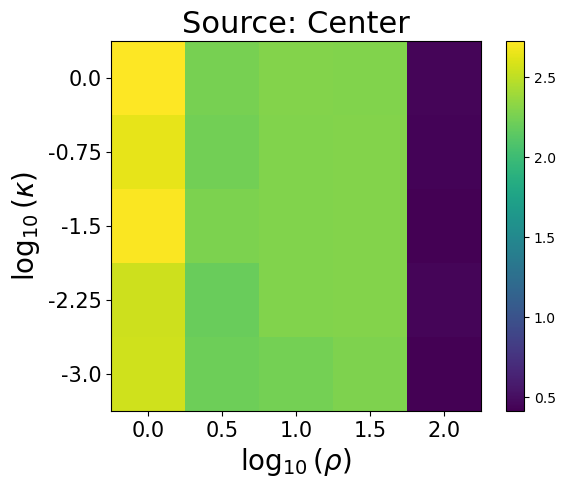

In [30]:
plt.imshow(energies, origin='lower')
plt.xlabel(r'$\log_{10}(\rho)$', fontsize=20);
plt.ylabel(r'$\log_{10}(\kappa)$', fontsize=20);
plt.xticks(ticks=np.arange(N_rhos), labels=np.log10(rhos), fontsize=15);
plt.yticks(ticks=np.arange(N_kappas), labels=np.log10(kappas), fontsize=15);
plt.colorbar();
plt.title('Source: Center', fontsize=22)

# Vary aspect ratio

In [5]:
def make_ellipse_netw(netw, a, b):
    center_ind = network_indices(netw)['center']

    max_dist = np.max(np.linalg.norm(netw.pos - netw.pos[center_ind], axis=1))
    a = a/max_dist
    b = b/max_dist
    
    ellipse_dist_fn = lambda x: (x[:, 0] - x[center_ind,0])**2/a**2 + (x[:, 1]-x[center_ind,1])**2/b**2
    ellipse_dists = ellipse_dist_fn(netw.pos)
    
    inside_ellipse_ids = np.where(ellipse_dists <= 1.)[0]
    new_pos = netw.pos[inside_ellipse_ids]
    new_ids = np.arange(len(new_pos))
    
    def get_ellipse_edges(edges, ellipse_ids):
        ellipse_edges = []
        for e in edges:
            is_in_ellipse = np.any(e[0]==ellipse_ids) and np.any(e[1]==ellipse_ids)
            if is_in_ellipse:
                #find the new ids of the nodes to form edges
                e1 = new_ids[np.where(e[0]==inside_ellipse_ids)[0][0]]
                e2 = new_ids[np.where(e[1]==inside_ellipse_ids)[0][0]]
                ellipse_edges += [[e1, e2]]        
        return np.array(ellipse_edges)

    new_edges = get_ellipse_edges(netw.edgelist, inside_ellipse_ids)
    
    return network_from_edges_and_nodes(new_edges, new_pos)

In [31]:
# define aspect ratio of ellipse by varying a, b
a = 1.
b = 0.6
netw = network_from_txt("../lattices/paper_edges.txt", "../lattices/paper_nodes.txt")
ellipse_netw = make_ellipse_netw(netw, a, b)
inds_ellipse = network_indices(ellipse_netw)
i_ellipse = inds_ellipse['left']

(0.5937104580000002, 2.946577722, -0.7307021658749999, 0.6605588591250005)

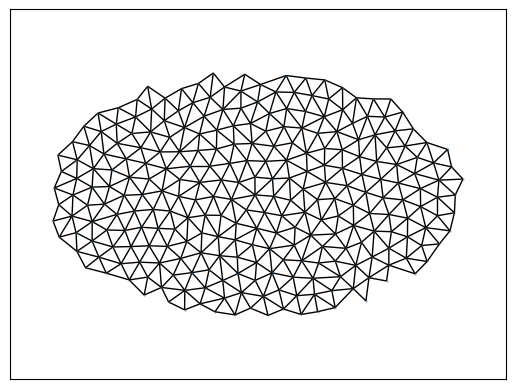

In [22]:
G = nx.Graph()
node_pos = ellipse_netw.pos
nodes = np.arange(len(node_pos))
node_dict = {}
for n in nodes:
    node_dict[n] = node_pos[n]

edges = ellipse_netw.edgelist
G.add_nodes_from(nodes)
G.add_edges_from(edges)


nx.draw_networkx(G, pos=node_dict, width=1., with_labels=False, node_size=0.1)
plt.axis('equal')


In [32]:
N_kappas = 5
N_rhos = 5
N_sinks = 50
N_replicates=10

kappas = np.logspace(-3, 0, N_kappas)
rhos = np.logspace(0, 2, N_rhos)

gamma = 0.5
beta = 1.0 / (1 + gamma)


energies = np.zeros((N_kappas, N_rhos))
for k in tqdm(range(N_kappas)):
    for p in range(N_rhos):
        kappa = kappas[k]
        rho = rhos[p]
        
        E = 0
        for _ in range(N_replicates):
            K0 = -np.log10(np.random.rand(ellipse_netw.N_e))
            sink_nodes = np.random.randint(0, ellipse_netw.N_v, size=N_sinks)
            currents = lambda K, netw: static_currents(K, ellipse_netw, source_index=i_ellipse, sink_nodes=sink_nodes)
            K, converged = ss_solve(lambda K, t: adaptation_ode(K, t, ellipse_netw, currents, kappa, beta, rho), K0, Δt=1.0)
            if not converged:
                print(f"Did not converge at k={kappa}, p={rho}")
                
                
            I = np.sqrt(currents(K, ellipse_netw))
            R = ellipse_netw.lengths/K
            E += np.mean(I*R)
        
        energies[k, p] = E/N_replicates
        
np.save(f'energies_a{a}_b{b}_source{i_ellipse}.txt', energies, allow_pickle=False)

100%|█████████████████████████████████████████████| 5/5 [06:23<00:00, 76.75s/it]


Text(0.5, 1.0, 'Source: Left, Aspect ratio: 1.0/0.6')

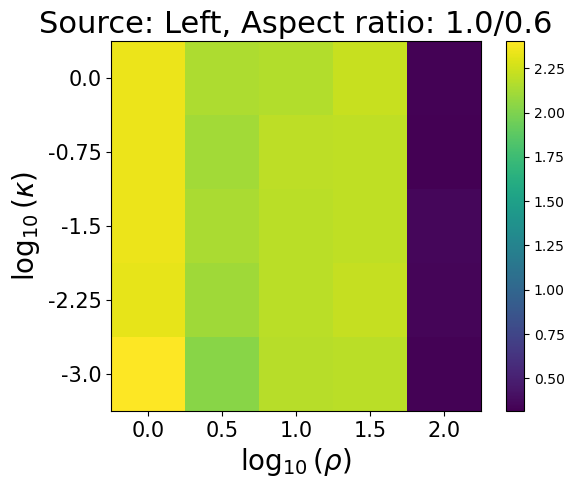

In [33]:
plt.imshow(energies, origin='lower')
plt.xlabel(r'$\log_{10}(\rho)$', fontsize=20);
plt.ylabel(r'$\log_{10}(\kappa)$', fontsize=20);
plt.xticks(ticks=np.arange(N_rhos), labels=np.log10(rhos), fontsize=15);
plt.yticks(ticks=np.arange(N_kappas), labels=np.log10(kappas), fontsize=15);
plt.colorbar();
plt.title(f'Source: Left, Aspect ratio: {a}/{b}', fontsize=22)

In [35]:
i_ellipse = inds_ellipse['center']

energies = np.zeros((N_kappas, N_rhos))
for k in tqdm(range(N_kappas)):
    for p in range(N_rhos):
        kappa = kappas[k]
        rho = rhos[p]
        
        E = 0
        for _ in range(N_replicates):
            K0 = -np.log10(np.random.rand(ellipse_netw.N_e))
            sink_nodes = np.random.randint(0, ellipse_netw.N_v, size=N_sinks)
            currents = lambda K, netw: static_currents(K, ellipse_netw, source_index=i_ellipse, sink_nodes=sink_nodes)
            K, converged = ss_solve(lambda K, t: adaptation_ode(K, t, ellipse_netw, currents, kappa, beta, rho), K0, Δt=1.0)
            if not converged:
                print(f"Did not converge at k={kappa}, p={rho}")
                
                
            I = np.sqrt(currents(K, ellipse_netw))
            R = ellipse_netw.lengths/K
            E += np.mean(I*R)
        
        energies[k, p] = E/N_replicates
        
np.save(f'energies_a{a}_b{b}_source{i_ellipse}.txt', energies, allow_pickle=False)

100%|█████████████████████████████████████████████| 5/5 [04:56<00:00, 59.28s/it]


Text(0.5, 1.0, 'Source: Center, Aspect ratio: 1.0/0.6')

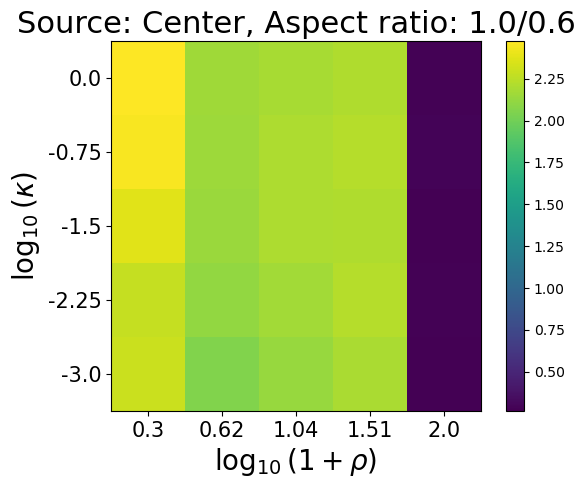

In [44]:
plt.imshow(energies, origin='lower')
plt.xlabel(r'$\log_{10}(1+\rho)$', fontsize=20);
plt.ylabel(r'$\log_{10}(\kappa)$', fontsize=20);
plt.xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1+rhos), 2), fontsize=15);
plt.yticks(ticks=np.arange(N_kappas), labels=np.log10(kappas), fontsize=15);
plt.colorbar();
plt.title(f'Source: Center, Aspect ratio: {a}/{b}', fontsize=22)

In [43]:
np.log10(1+rhos)

array([0.30103   , 0.61933105, 1.04139269, 1.51352092, 2.00432137])

- plot log10(1+rho) (fix labels)
- dissipation is sum over pressures only at sources and sinks
- more regular arrangement of nodes: overlay hexagonal grid on the nodes & select 50 points from the set of centers of the hexagons (delauney vornoi)